In [1]:
import networkx as nx
import random as ra
import matplotlib.pyplot as pltt
import numpy as np
import pandas as pd
from collections import Counter
import scipy as scp
import copy
import itertools

# 1.1.Wrong Equation
- p{G is connected}=p{z=0} where G is a graph and z is the number of isolated nodes.
- the equation given in part 1.3 is incorrect consider the case below:

,degree_of_node
node,
1,1
2,2
3,2
4,1
5,2
6,2
7,2


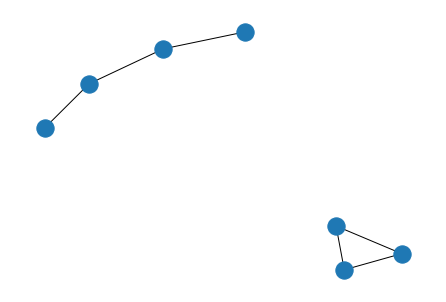

In [2]:
G = nx.Graph()  
G1 = [(1, 2), (2, 3), (3, 4)] 
G2 = [(5, 6), (6, 7), (5, 7)]
G = nx.Graph(G1+G2)
nodes = G.nodes()
degreesDf = pd.DataFrame({"node":nodes,"degree_of_node":list(d for n, d in G.degree())})
nx.draw(G)   
degreesDf.set_index("node")

- as you can see in the case above when we have a disconnected graph named G which consist of two connected part G1 , G2 the number of isolated nodes is zero but this graph is not connected.
- so the equation given should be writen as below:
- in general P{G is connected} < p{z=0} and one can say that a connected graph does not have any isolated node but one can't say every graph that does not have an isolated node is connected so:
- p{G is connected} => p{z=0} but the equation
-p{z=0}=>p{G is connected} is not correct.

 # 1.3.1.The probability of absence of isolated vertice 
 - if we have a connected graph and each vertice has an independant probability of being damaged then the probablity of a node being isolated is:
- the node must not be damaged(1-p) and it's neighbors must be damaged(p)
$$P(\text{v is isolated})= p^{ki}(1-p)$$
- then the probability of having all vertices being isolated is the sum of the above equation for each vertices:
$$P(\text{z=n})=\sum_{i \in v} p^{ki}(1-p)=(1-p)\sum_{i \in v} p^{ki}$$

In [3]:
def reliability_isolated(graph, p):
    degrees=graph.degree()
    sigma = 0
    for node , degree in degrees:
        sigma = sigma + np.power(p,degree)
    ans = sigma * (1-p)
    return np.power(np.e,-ans)

In [4]:
G = nx.erdos_renyi_graph(10,0.5)
reliability_isolated(G,0.5)

0.604166020765368

# 1.5 Finding the number of cut sets

In [5]:
def calculate_cutset(graph):
    vertices = set(graph.nodes())
    ans = [0] * len(vertices)
    if nx.is_connected(graph):
        ans = numberOfCutsets(graph)
    return ans


def numberOfCutsets(graph):
    vertices = set(graph.nodes())
    ans = [0] * len(vertices)
    for i in range(len(vertices)-1):
        subsets = list(itertools.combinations(vertices,i))
        for subset in subsets:
            graphcopy = copy.deepcopy(graph)
            graphcopy.remove_nodes_from(subset)
            if not (nx.is_connected(graphcopy)) :
                ans[i] = ans[i] + 1
#                 print(subset)
    return ans

[0, 0, 1, 10, 41, 84, 95, 62, 22, 0]


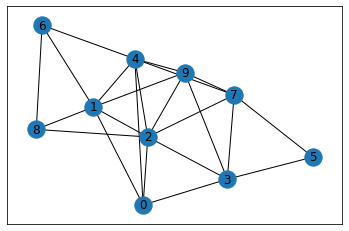

In [6]:
G = nx.erdos_renyi_graph(10,0.5)
nx.draw_networkx(G)
print(calculate_cutset(G))

In [7]:
def residualConnectivity(graph , p):
    ci = calculate_cutset(graph)
    fi = 0
    multiplier = np.power(1-p,len(ci))
    for i in range(len(ci)):
        fi = fi + ci[i]*multiplier
        multiplier = multiplier * p/(1-p)
    return fi    
        
def reliabilityRC(graph , p):
    return 1 - residualConnectivity(graph , p)

0.9052734375
0.870513618882206


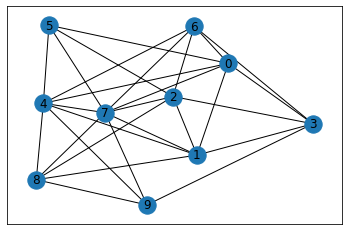

In [8]:
G = nx.erdos_renyi_graph(10,0.5)
nx.draw_networkx(G)
print(reliabilityRC(G,0.5))
print(reliability_isolated(G,0.5))

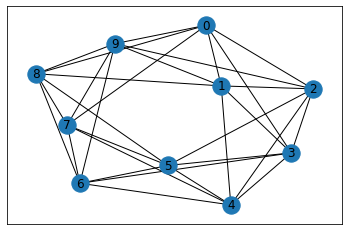

In [9]:
graph = nx.watts_strogatz_graph(10 , 6, 0)
nx.draw_networkx(graph)

In [10]:
def reliability_simulation(graph , p):
    vertices = list(graph.nodes())
    todel=[]
    for i in range(len(vertices)):
        h = np.random.sample()
        if(h < p):
            todel.append(i)
    graph.remove_nodes_from(todel)
    if len(list(graph.nodes())) == 0:
        return 0.0
    if nx.is_connected(graph):
        return 1.0
    return 0.0           

In [11]:
def montCarloForNodeElimination(iterate=10, graph_type='ER',p_remove=0.01,n=10,p=0.5,m =3):
    result = {"reliabilityCalcultedByRC":0.0,"reliabilityCalcultedByisolated":0.0,"simulation":{}}
    
    for i in range(iterate):
        if graph_type=='ER':
            graph =  nx.erdos_renyi_graph(n,p)
            while not nx.is_connected(graph):
                graph =  nx.erdos_renyi_graph(n,p)
        elif graph_type=='WS':
            graph = nx.watts_strogatz_graph(n , m, p)
            while not nx.is_connected(graph):
                graph =  nx.watts_strogatz_graph(n , m, p)
        elif graph_type=='BA':
            graph = nx.barabasi_albert_graph(n,m)
            while not nx.is_connected(graph):
                graph =  nx.barabasi_albert_graph(n,m)
        else:
            print('this type of graph is not impelemented!')
            return result
        graphcopy = copy.deepcopy(graph)
        result["simulation"]["iter"+str(i+1)]=reliability_simulation(graphcopy,p_remove)
        graphcopy = copy.deepcopy(graph)
        result["reliabilityCalcultedByRC"]=result["reliabilityCalcultedByRC"]+reliabilityRC(graphcopy,p_remove)
        graphcopy = copy.deepcopy(graph)
        result["reliabilityCalcultedByisolated"]= result["reliabilityCalcultedByisolated"]+reliability_isolated(graphcopy,p_remove) 
    
    result["reliabilityCalcultedByisolated"]= result["reliabilityCalcultedByisolated"]/iterate
    result["reliabilityCalcultedByRC"]=result["reliabilityCalcultedByRC"]/iterate
    return result    

In [12]:
def simFordiffP(iterate=1000, graph_type='ER',gap=0.05,n=10,p=0.5,m =3):
    result={}
    for i in range(int(1/gap)):
        this = montCarloForNodeElimination(iterate,graph_type,i*gap,n,p,m)
        std = pd.Series(this.get('simulation')).aggregate('std')
        Simulation = pd.Series(this.get('simulation')).aggregate('mean')
        this['simulation'] = Simulation
        this["error"]=std/np.sqrt(iterate)
        result[str(round(i*gap,2))]=this
    return result

# ER

In [13]:
result = simFordiffP(100,'ER',0.01,10,0.7,5)
DfER = pd.DataFrame(result)
DfER=DfER.T

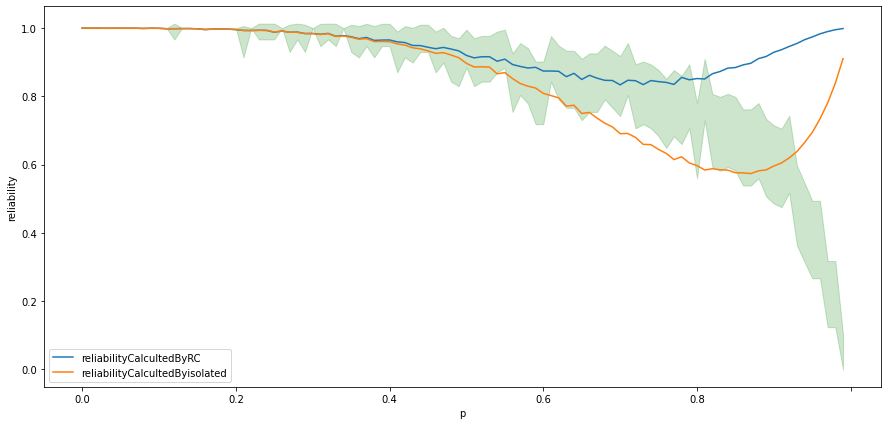

In [15]:
plt = DfER[["reliabilityCalcultedByRC","reliabilityCalcultedByisolated"]].plot(figsize=(15,7),xlabel="p",ylabel="reliability")
z = 2.33
#99.01 percentage confidence
plt.fill_between(DfER.index,DfER['simulation']-z*DfER['error'],DfER['simulation']+z*DfER['error'],color='green',alpha=0.2)

In [16]:
z = 2.33
A=(DfER["reliabilityCalcultedByRC"] <= (DfER["simulation"]+z*DfER["error"]))
B = (DfER["reliabilityCalcultedByRC"] >= (DfER["simulation"]-z*DfER["error"] ))
DfER['isinintervelreliabilityCalcultedByRC'] = A&B
A=(DfER["reliabilityCalcultedByisolated"] <= (DfER["simulation"]+z*DfER["error"]))
B = (DfER["reliabilityCalcultedByisolated"] >= (DfER["simulation"]-z*DfER["error"] ))
DfER['isinintervalreliabilityCalcultedByisolated'] =A&B

In [17]:
print("the value calculated by reliabilityCalcultedByRC function in ER graphs is "+f"{(DfER['isinintervelreliabilityCalcultedByRC'].mean()*100)}"+" percentage of time in confidence interval")
print("the value calculated by reliabilityCalcultedByisolated function in ER graphs is "+f"{(DfER['isinintervalreliabilityCalcultedByisolated'].mean()*100)}"+" percentage of time in confidence interval")

the value calculated by reliabilityCalcultedByRC function in ER graphs is 57.99999999999999 percentage of time in confidence interval
the value calculated by reliabilityCalcultedByisolated function in ER graphs is 49.0 percentage of time in confidence interval


# WS

In [18]:
result = simFordiffP(100,'WS',0.01,10,0.7,6)
DfWS = pd.DataFrame(result)
DfWS = DfWS.T

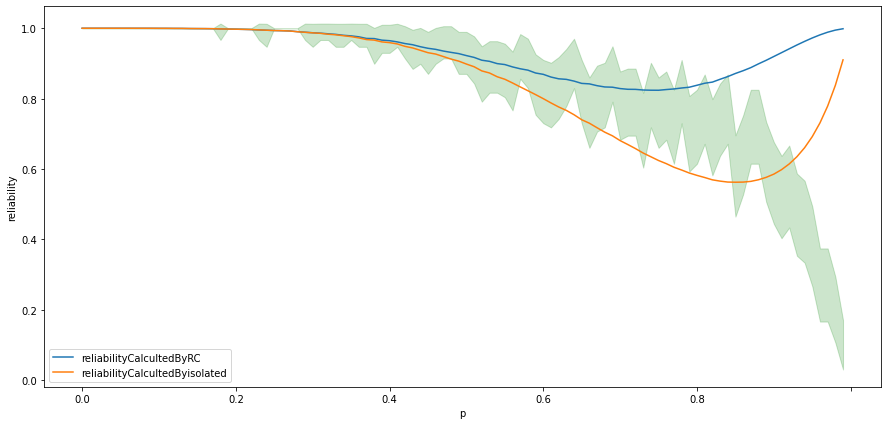

In [20]:
plt = DfWS[["reliabilityCalcultedByRC","reliabilityCalcultedByisolated"]].plot(figsize=(15,7),xlabel="p",ylabel="reliability")
z = 2.33
#99.01 percentage confidence
plt.fill_between(DfWS.index,DfWS['simulation']-z*DfWS['error'],DfWS['simulation']+z*DfWS['error'],color='green',alpha=0.2)

In [21]:
z = 2.33
A=(DfWS["reliabilityCalcultedByRC"] <= (DfWS["simulation"]+z*DfWS["error"]))
B = (DfWS["reliabilityCalcultedByRC"] >= (DfWS["simulation"]-z*DfWS["error"] ))
DfWS['isinintervelreliabilityCalcultedByRC'] = A&B
A=(DfWS["reliabilityCalcultedByisolated"] <= (DfWS["simulation"]+z*DfWS["error"]))
B = (DfWS["reliabilityCalcultedByisolated"] >= (DfWS["simulation"]-z*DfWS["error"] ))
DfWS['isinintervalreliabilityCalcultedByisolated'] =A&B

In [22]:
print("the value calculated by reliabilityCalcultedByRC function in small world graphs is "+f"{(DfWS['isinintervelreliabilityCalcultedByRC'].mean()*100)}"+" percentage of time in confidence interval")
print("the value calculated by reliabilityCalcultedByisolated function in small world graphs is "+f"{(DfWS['isinintervalreliabilityCalcultedByisolated'].mean()*100)}"+" percentage of time in confidence interval")

the value calculated by reliabilityCalcultedByRC function in small world graphs is 54.0 percentage of time in confidence interval
the value calculated by reliabilityCalcultedByisolated function in small world graphs is 45.0 percentage of time in confidence interval


# BA

In [23]:
result = simFordiffP(100,'BA',0.01,10,0.7,6)
DfBA = pd.DataFrame(result)
DfBA = DfBA.T

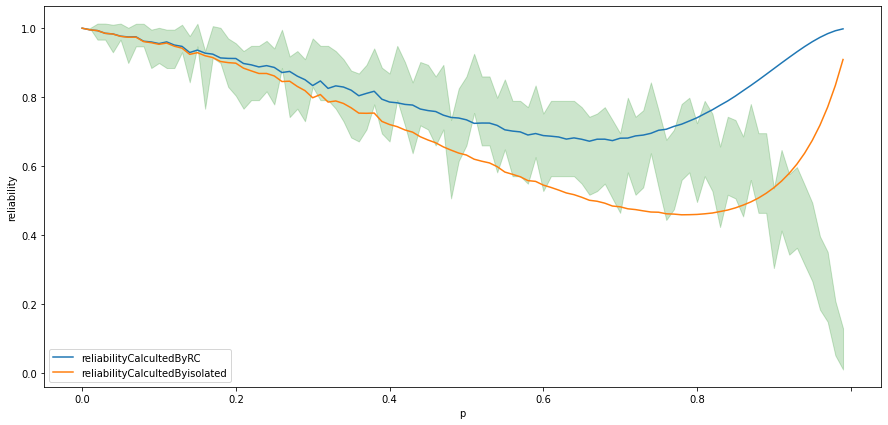

In [25]:
plt = DfBA[["reliabilityCalcultedByRC","reliabilityCalcultedByisolated"]].plot(figsize=(15,7),xlabel="p",ylabel="reliability")
z = 2.33
#99.01 percentage confidence
plt.fill_between(DfBA.index,DfBA['simulation']-z*DfBA['error'],DfBA['simulation']+z*DfBA['error'],color='green',alpha=0.2)

In [26]:
z = 2.33
A=(DfBA["reliabilityCalcultedByRC"] <= (DfBA["simulation"]+z*DfBA["error"]))
B = (DfBA["reliabilityCalcultedByRC"] >= (DfBA["simulation"]-z*DfBA["error"] ))
DfBA['isinintervelreliabilityCalcultedByRC'] = A&B
A=(DfBA["reliabilityCalcultedByisolated"] <= (DfBA["simulation"]+z*DfBA["error"]))
B = (DfBA["reliabilityCalcultedByisolated"] >= (DfBA["simulation"]-z*DfBA["error"] ))
DfBA['isinintervalreliabilityCalcultedByisolated'] =A&B

In [27]:
print("the value calculated by reliabilityCalcultedByRC function in BA graphs is "+f"{(DfBA['isinintervelreliabilityCalcultedByRC'].mean()*100)}"+" percentage of time in confidence interval")
print("the value calculated by reliabilityCalcultedByisolated function in BA graphs is "+f"{(DfBA['isinintervalreliabilityCalcultedByisolated'].mean()*100)}"+" percentage of time in confidence interval")

the value calculated by reliabilityCalcultedByRC function in BA graphs is 73.0 percentage of time in confidence interval
the value calculated by reliabilityCalcultedByisolated function in BA graphs is 50.0 percentage of time in confidence interval
